In [1]:
import numpy as np
import pandas as pd
from scipy import stats

import plotly
import plotly.express as px

pd.options.mode.chained_assignment = None  # default='warn'
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

pd. options. plotting. backend = "plotly"

import plotly.io as pio
pio.renderers.default = 'jupyterlab'

pd.set_option('precision',4)

import statsmodels.api as sm
import statsmodels.formula.api as smf

# Yield curve historical data

In [2]:
# Obtained from 
# https://www.treasury.gov/resource-center/data-chart-center/interest-rates/Pages/TextView.aspx?data=yield

USTYC = pd.read_csv("USTreasury_YieldCurve.csv")

KeepCols = ['Date','3 Mo','6 Mo','1 Yr','2 Yr','5 Yr','10 Yr','20 Yr','30 Yr']
USTYC = USTYC.loc[:,KeepCols]
USTYC.columns = USTYC.columns.str.replace(' ','')

USTYC["Date"] = pd.to_datetime(USTYC["Date"],format="%m/%d/%y")
YCols = USTYC.columns.difference(["Date"])
USTYC[YCols] = USTYC[YCols]/100
USTYC = USTYC.rename(columns=dict(zip(YCols,['T'+x for x in YCols])))

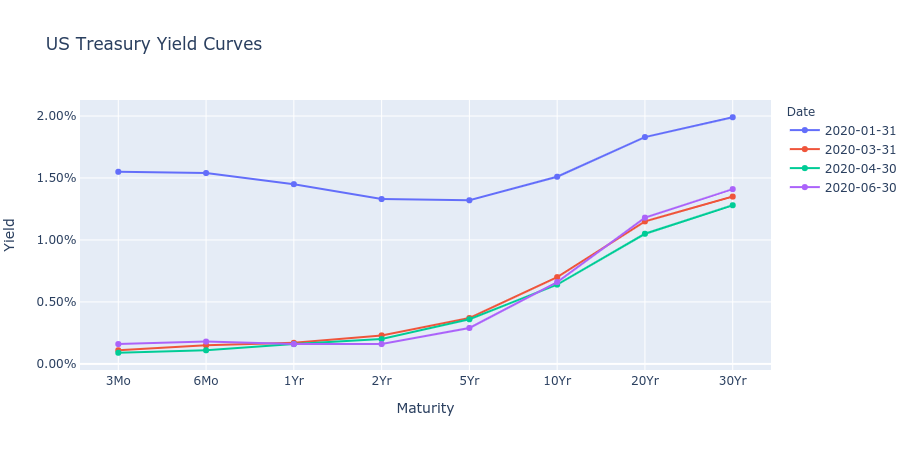

In [3]:
YCDates = ['20200131','20200229','20200331','20200430','20200531','20200630']

plotDF = pd.melt(USTYC,id_vars="Date",var_name="Maturity",value_name="Yield")
plotDF = plotDF.loc[plotDF["Date"].isin(YCDates),:].reset_index(drop=True)
plotDF["Maturity"] = plotDF["Maturity"].str.slice(start=1)
plotDF["Date"] = plotDF["Date"].dt.date.astype(str)

px.line(plotDF,x="Maturity",y="Yield",color="Date",title="US Treasury Yield Curves")\
.update_layout(yaxis=dict(tickformat=".2%")).update_traces(mode='lines+markers')

# PCA

## Background

Let $\mathbf{X}$ be an $n\times k$ matrix whose columns are centered - i.e., the mean of each column is zero. Then the $k\times k$ covariance matrix $\mathbf{\Sigma}$ is

\begin{equation}
\mathbf{\Sigma} = \frac{1}{n}\mathbf{X'X}
\end{equation}

We can diagonalize the covariance matrix by the similarity transformation

\begin{equation}
\mathbf{\Sigma} = \mathbf{U\Lambda U'}
\end{equation}
where
* $\mathbf{U}$ is a $k\times k$ matrix whose columns are eigenvectors of $\mathbf{\Sigma}$
* $\mathbf{U}$ is an orthogonal matrix, $\mathbf{UU'= U'U = I}$
* $\mathbf{\Lambda}$ is a diagonal matrix consisting of the eigenvalues of $\mathbf{\Sigma}$

In addition:

* If $\mathbf{\Sigma}$ is real and symmetric, its eigenvalues are real
* If the eigenvalues $\lambda_i > 0 \; \forall\, i$, then $\mathbf{\Sigma}$ is positive definite
* If some $\lambda_i = 0$, then $\mathbf{\Sigma}$ is positive semi-definite if the *non-zero* $\lambda_i$ are greater than zero

**Variation and reduction in dimensionality**

$$
\text{Total variation} = \sum_i \sigma_i^2 = tr(\mathbf{\Sigma}) = tr(\mathbf{\Lambda}) = \sum_i \lambda_i
$$
where $tr(.)$ is the trace of a matrix and we have used the fact that $tr(\mathbf{\Sigma})=tr(\mathbf{U\Lambda U'})=tr(\mathbf{U'U\Lambda})=tr(\mathbf{\Lambda})$.

The vectors in $\mathbf{X}$ can be transformed to a new basis by post-multiplying them with the matrix $\mathbf{U}$:

\begin{equation}
\mathbf{P} = \mathbf{X U}
\end{equation}

The columns of $\mathbf{P}$ are known as principal components. These components are orthogonal to each other. The $j$th principal component is 

\begin{equation}
\mathbf{P}_j = \mathbf{X}\mathbf{U}_j
\end{equation}
where $\mathbf{U}_j$ is the $j$th column of $\mathbf{U}$.

The proportion of total variation explained by the $j$th principal component is $\frac{\lambda_i}{\sum_i \lambda_i}$. Often, a few principal components can account for a large fraction of the variation. Thus we may choose to ignore the eigenvectors corresponding to the smaller eigenvalues. This is what leads to **dimensionality reduction**.

The matrix $\mathbf{X}$ can be recovered by noting that $\mathbf{X}=\mathbf{PU'}$.

**Relationship to Singular Value Decomposition (SVD)**

Singular value decomposition is a non-unique decomposition of the matrix $\mathbf{X}$ such that

$$
\mathbf{X}_{n\times k} = \mathbf{V}_{n\times n} \mathbf{S}_{n\times k} \mathbf{U'}_{k\times n}
$$

and 
* $\mathbf{V, U}$ are unitary (orthogonal if $\mathbf{X}$ is real)
* $\mathbf{S}$ is diagonal

From this, we see that

$$
\mathbf{\Sigma} = \frac{1}{n}\mathbf{X'X} = \frac{1}{n} \mathbf{U\,S\,V'\,V\,S\,U'} = \frac{1}{n} \mathbf{U\, S^2\, U'}
$$

which means that $\frac{1}{n} \mathbf{S^2} = \mathbf{\Lambda}$. Since $\mathbf{S}$ is diagonal, it follows that

$$
\frac{1}{n} s_i^2 = \lambda_i
$$

## Implementation

In [4]:
from sklearn.decomposition import PCA
np.set_printoptions(precision=3, suppress=True)

# PCA factors for US Treasury yield curve changes

In [5]:
YCdf = USTYC.set_index("Date").diff().dropna()       # daily changes
YCX = YCdf.values

In [6]:
# Running PCA on the entire panel

dvec = YCdf.index

pca = PCA()          # Creating an object
fit = pca.fit(YCX)

evr = np.cumsum(fit.explained_variance_ratio_)
PC = pd.DataFrame(pca.fit_transform(YCX), columns=['PC'+str(x) for x in range(pca.n_components_)])
PC = pd.concat([pd.Series(dvec),PC],axis=1)

print(100*evr)
#PC

[ 71.314  89.542  95.239  97.401  98.51   99.316  99.729 100.   ]
